In [2]:
#prepare all the library that may be used 

import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso, Ridge
from sklearn.neural_network import MLPClassifier, MLPRegressor 
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import warnings
warnings.filterwarnings('ignore')

TO check the basic information for our dataset

In [3]:
df=pd.read_csv(r"C:\Users\11453\Desktop\python code\5720\assignment2\insurance.csv")
df.head(10)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\11453\\Desktop\\python code\\5720\\assignment2\\insurance.csv'

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Then we need to prepare our training set, after we know the type and value for each column, we can do encoding and normalization to the colums,which are not in the right type.

In [13]:
#define the y and x
y= df.loc[:,"charges"]
x_orig=df.loc[:,"age":"region"]

x_enco=x_orig.copy()
x_enco.loc[:,"sex"]=(x_enco.loc[:,"sex"]=="male").astype(int)
x_enco.loc[:,"smoker"]=(x_enco.loc[:,"smoker"]=="yes").astype(int)

x_enco = pd.get_dummies(x_enco, columns=['region'], prefix='region', drop_first=False)

In [14]:
x_train, x_test, y_train, y_test =train_test_split(x_enco,y,test_size=0.3,random_state=12345)

firstly we are going to try Linear Regression

In [15]:
try:
    X_train = x_train.copy() if hasattr(x_train, "copy") else x_train
    X_test  = x_test.copy()  if hasattr(x_test,  "copy") else x_test
    y_tr = y_train.copy()    if hasattr(y_train, "copy") else y_train
    y_te = y_test.copy()     if hasattr(y_test,  "copy") else y_test
except NameError:
    raise NameError("请先在 notebook 中定义 x_train, x_test, y_train, y_test（或预先生成 X_train_s/X_test_s）。")

# 若是 DataFrame，保证 test 的列顺序与 train 一致，缺失列填 0（常用于 one-hot）
if hasattr(X_train, "columns"):
    X_test = X_test.reindex(columns=X_train.columns).fillna(0)

# --------- 缩放：优先使用已存在的缩放变量，否则新建 scaler ----------
if 'X_train_s' in globals() and 'X_test_s' in globals():
    X_train_s = X_train_s
    X_test_s = X_test_s
elif 'X_train_scaled' in globals() and 'X_test_scaled' in globals():
    X_train_s = X_train_scaled
    X_test_s = X_test_scaled
else:
    scaler_local = StandardScaler()
    X_train_s = scaler_local.fit_transform(X_train)
    X_test_s  = scaler_local.transform(X_test)

In [16]:

results = []
def collect(name, model, Xtr, Xte, ytr, yte, best_params=None):
    ypred = model.predict(Xte)
    res = {
        "model": name,
        "r2": r2_score(yte, ypred),
        "rmse": np.sqrt(mean_squared_error(yte, ypred)),
        "mae": mean_absolute_error(yte, ypred),
        "best_params": best_params
    }
    results.append(res)
    print(f"{name} -> R2: {res['r2']:.4f}, RMSE: {res['rmse']:.4f}, MAE: {res['mae']:.4f}")
    return res

# --------- 1) Baseline Linear Regression ----------
lr = LinearRegression()
lr.fit(X_train_s, y_tr)
collect("LinearRegression", lr, X_train_s, X_test_s, y_tr, y_te)



LinearRegression -> R2: 0.7537, RMSE: 5944.9887, MAE: 4020.9000


{'model': 'LinearRegression',
 'r2': 0.7536863523579089,
 'rmse': np.float64(5944.988725179351),
 'mae': 4020.899965415797,
 'best_params': None}

In [17]:
# --------- 2) Lasso (小网格搜索，稳定运行 n_jobs=1) ----------
lasso = Lasso(max_iter=10000, random_state=42)
lasso_grid = GridSearchCV(
    lasso,
    param_grid={"alpha":[1e-4, 1e-3, 1e-2, 1e-1]},
    cv=5, scoring="r2", n_jobs=1, verbose=0
)
lasso_grid.fit(X_train_s, y_tr)
best_lasso = lasso_grid.best_estimator_
collect("Lasso", best_lasso, X_train_s, X_test_s, y_tr, y_te, best_params=lasso_grid.best_params_)


Lasso -> R2: 0.7537, RMSE: 5944.9664, MAE: 4020.8729


{'model': 'Lasso',
 'r2': 0.7536881990269022,
 'rmse': np.float64(5944.9664396766475),
 'mae': 4020.8728999945947,
 'best_params': {'alpha': 0.1}}

In [18]:

# --------- 3) Ridge (小网格搜索，稳定运行 n_jobs=1) ----------
ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(
    ridge,
    param_grid={"alpha":[0.01, 0.1, 1.0, 10.0]},
    cv=5, scoring="r2", n_jobs=1, verbose=0
)
ridge_grid.fit(X_train_s, y_tr)
best_ridge = ridge_grid.best_estimator_
collect("Ridge", best_ridge, X_train_s, X_test_s, y_tr, y_te, best_params=ridge_grid.best_params_)

# --------- 汇总结果与系数展示 ----------
res_df = pd.DataFrame(results).sort_values("r2", ascending=False).reset_index(drop=True)
print("\nModel comparison:")
display(res_df)

Ridge -> R2: 0.7543, RMSE: 5937.8935, MAE: 4032.1820

Model comparison:


,model,r2,rmse,mae,best_params
0,Ridge,0.754274,5937.893518,4032.181953,{'alpha': 10.0}
1,Lasso,0.753688,5944.966440,4020.872900,{'alpha': 0.1}
2,LinearRegression,0.753686,5944.988725,4020.899965,None


Then we use decision tree

In [19]:
# 1. 初始化模型
# 使用 random_state=0 确保结果可复现
dt_baseline = DecisionTreeRegressor(random_state=0)

# 2. 训练模型
dt_baseline.fit(x_train, y_train)

# 3. 评估模型
y_pred_dt_baseline = dt_baseline.predict(x_test)

print("---The baseline decision tree model (unpruned)---")
print(f'R2 Score: {metrics.r2_score(y_test, y_pred_dt_baseline):.4f}')
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred_dt_baseline):.4f}')
# sample.ipynb 中使用了 RMSE
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt_baseline)):.4f}')

# 检查树的深度
print(f'\nMaximum depth of decision tree: {dt_baseline.get_depth()}')

---The baseline decision tree model (unpruned)---
R2 Score: 0.7287
MAE: 2813.1637
RMSE: 6239.6285

Maximum depth of decision tree: 18


1.建立一个基准的决策树模型来解决一个连续数值的回归问题，同时 random_state=0 确保每次运行代码时，树的构建方式都一样，使结果可复现。

2.使用训练数据来训练基准模型

3.用训练好的数据对它“没见过”的测试数据 (x_test) 进行预测。最后检查树的深度，存在在测试数据上表现不佳（R2分数不高），它存在严重的过度拟合的情况。


In [1]:
# 1. 定义参数网格
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],          # Try different tree depths
    'min_samples_leaf': [5, 10, 20, 30],      # Minimum number of samples required for leaf nodes
    'min_samples_split': [10, 20, 40]     # Minimum number of samples required for internal node splitting
}

# 2. 初始化 GridSearchCV
# 我们使用 'r2' 作为评分标准
# cv=5 表示5折交叉验证
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1, # 使用所有可用的CPU
    verbose=1  # 显示搜索过程
)

# 3. 在训练数据上运行网格搜索
print("Start searching for optimal parameters...")
grid_search.fit(x_train, y_train)

# 4. 打印最佳参数
print("\nSearch complete.")
print("Find the optimal parameter combination：")
print(grid_search.best_params_)

# 5. 获取最佳模型
# grid_search.best_estimator_ 是使用最佳参数在 *整个* X_train 上自动重新训练好的模型
dt_optimized = grid_search.best_estimator_

NameError: name 'GridSearchCV' is not defined

1.为防止过拟合，需要对树进行剪枝，通过定义param_grid (参数网格)，列出我们想要尝试的所有超参数组合，来对树的最大深度，一个叶节点必须包含的最小样本数以及一个节点在分裂前必须包含的最小样本数进行组合。

2.使用 GridSearchCV (网格搜索交叉验证) 来自动帮我们测试 param_grid 中的所有组合。同时将训练数据分成5份轮流使用4分训练、一份验证，来评估参数组合的好坏。

3.找到最佳参数组合后将其命名为dt_optimized

In [21]:
 #1. 使用优化后的模型进行预测
y_pred_dt_optimized = dt_optimized.predict(x_test)

print("--- 3.3 Evaluation of the optimized decision tree (after pruning) ---")
print(f'R2 Score: {metrics.r2_score(y_test, y_pred_dt_optimized):.4f}')
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred_dt_optimized):.4f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt_optimized)):.4f}')

print(f'\nMaximum depth of the optimized tree: {dt_optimized.get_depth()}')

--- 3.3 Evaluation of the optimized decision tree (after pruning) ---
R2 Score: 0.8649
MAE: 2368.5857
RMSE: 4402.1920

Maximum depth of the optimized tree: 5


In [ ]:
# 1. 获取特征重要性
importances = dt_optimized.feature_importances_

# 2. 获取特征名称
# 确保 X_train 在此单元格中是 DataFrame 格式
feature_names = x_train.columns

# 3. 创建一个 DataFrame 便于查看
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. 打印重要的特征
print("--- Feature Importance Ranking ---")
print(importance_df)

# 5. 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.title('Optimized Decision Tree - Feature Importance')
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # 将最重要的特征放在顶部
plt.show()

1.在优化后的模型中提取“重要性”分数来说明那些特征变量对预测结果最重要，并将其结果整理到表格里，再用条形图进行可视化。

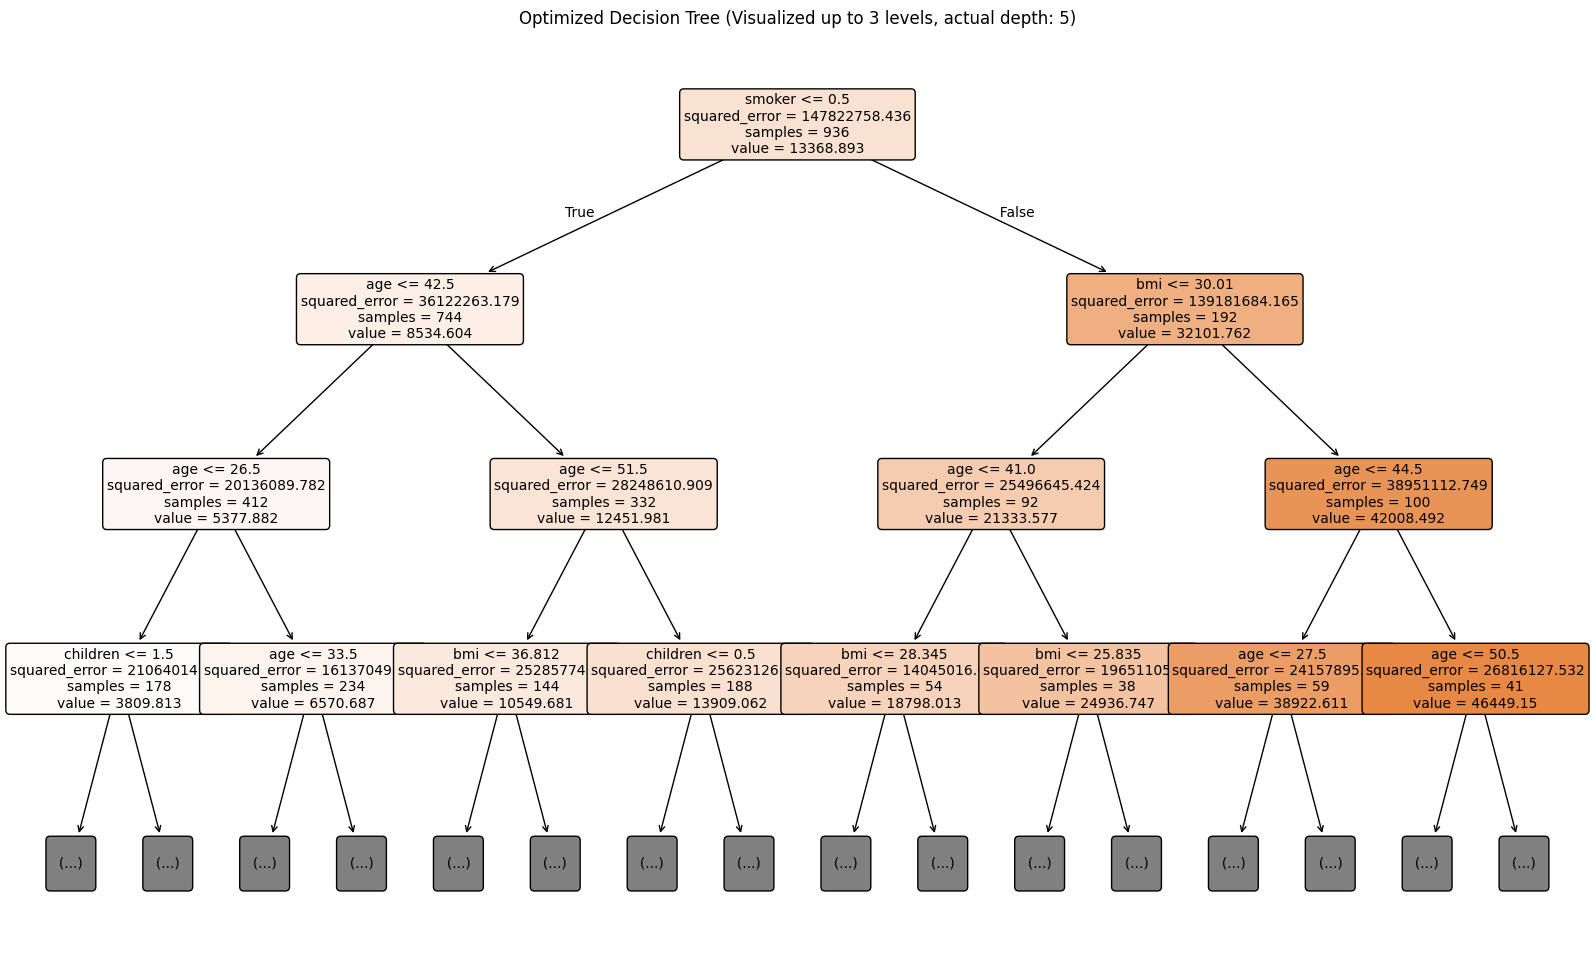

In [23]:
plt.figure(figsize=(20, 12)) # 调大图像尺寸以便看清

# 使用 plot_tree 可视化
# 我们只显示前3层 (max_depth=3)，以保持清晰
plot_tree(
    dt_optimized,
    feature_names=feature_names,
    filled=True,           
    rounded=True,          
    fontsize=10,           
    max_depth=3            
)

plt.title(f'Optimized Decision Tree (Visualized up to 3 levels, actual depth: {dt_optimized.get_depth()})')
plt.show()

1.最后可视化模型来帮助理解是如何进行决策的

Now we are going to use ANN methord to build a basic regression modle by MLPRegressor

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)   # fit 只在训练集
X_test_scaled  = scaler.transform(x_test)

In [25]:
model = MLPRegressor(hidden_layer_sizes=(64,32),
                     activation='relu',
                     solver='adam',
                     max_iter=500,
                     random_state=42)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("R2:", r2_score(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)   # 不传 squared 参数，返回 MSE
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R2: 0.787747615234531
RMSE: 5518.652989598743


Next we can use 